In [11]:
# !pip install torch
# !pip3 install torch_geometric
# !pip install torch torchvision
# !pip3 install tensorboard

# !pip3 install tensorflow==2.9.1
# !pip3 install tensorboardX
# !pip3 install numpy
# !pip3 install --upgrade h5py
# !pip3 install protobuf==3.20.0
!pip3 install matplotlib

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F

# num_classes = 3
# edge_index = torch.tensor([[0, 1, 1, 2, 3, 2],
#                            [1, 0, 2, 1, 2, 3]], dtype=torch.long)
# x = torch.tensor([[], [], [], []], dtype=torch.float)
# y = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]], dtype=torch.float)
# train_mask = torch.tensor([True, True, False, False], dtype=torch.bool)
# test_mask = torch.tensor([False, False, True, True], dtype=torch.bool)
# x
# data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
# data

In [9]:
from torch.utils.data import random_split

data = torch.load('GNN_data_filtered.pt')

# Assuming 'dataset' is your entire dataset
dataset_size = data.x.shape[0]
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(data.x, [train_size, test_size])

# Now you can create masks based on the lengths of train_dataset and test_dataset
train_mask = torch.zeros(dataset_size, dtype=torch.bool)
test_mask = torch.zeros(dataset_size, dtype=torch.bool)
train_mask[list(train_dataset.indices)] = True
test_mask[list(test_dataset.indices)] = True

data.test_mask = test_mask
data.train_mask = train_mask
num_classes = data.y.shape[1]
# print(dict(zip(data.categories, data.y_weights)))
data

Data(x=[2432, 0], edge_index=[2, 6609], edge_attr=[6609], y=[2432, 71], articles=[2432], categories=[71], test_mask=[2432], train_mask=[2432])

In [112]:
node1 = data.edge_index[0][9]
node2 = data.edge_index[1][9]
print(data.articles[node1])
print(data.articles[node2])
print(data.edge_attr[9])

Pasta al forno
Al forno
tensor(1.6167)


In [113]:
# tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [114]:
import torch_geometric.nn

class GCNModel(torch.nn.Module):
    def __init__(self, num_nodes, hidden_size=128):
        super(GCNModel, self).__init__()
        self.node_embedding = torch.nn.Embedding(num_nodes, hidden_size)
        # Initialize the embeddings with small random values
        torch.nn.init.normal_(self.node_embedding.weight, std=0.1)
        # self.conv1 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv1 = torch_geometric.nn.GCNConv(hidden_size, 16)
        self.conv2 = torch_geometric.nn.GCNConv(16, num_classes)

    def forward(self, data):
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        # x = self.node_embedding.weight
        x = data.x

        # x = self.conv1(x, edge_index)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return F.softmax(x, dim=1)
    
class GCNModelNodeFeat(torch.nn.Module):
    def __init__(self, num_nodes, num_features, hidden_size=128):
        super(GCNModelNodeFeat, self).__init__()
        # self.conv1 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv1 = torch_geometric.nn.GCNConv(num_features, hidden_size)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv3 = torch_geometric.nn.GCNConv(hidden_size, hidden_size)
        self.conv4 = torch_geometric.nn.GCNConv(hidden_size, num_classes)

    def forward(self, data):
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        # x = self.node_embedding.weight
        x = data.x

        # x = self.conv1(x, edge_index)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index, edge_attr)
        return F.softmax(x, dim=1)

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GCNModel(len(data.x)).to(device)
print(data.x.shape[1])
model = GCNModelNodeFeat(len(data.x), data.x.shape[1]).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# sets the model in training mode
# When you call model.train(), PyTorch enables features such as dropout and 
# batch normalization, which are typically used during training but not during inference
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=data.y_weights)
    loss.backward()
    if(epoch % 10 == 0):
        print(epoch, loss)
    writer.add_scalar("Loss/train", loss, epoch)
    
    max_index = torch.argmax(out, dim=1)
    binary_pred = torch.zeros_like(out)
    binary_pred[torch.arange(out.size(0)), max_index] = 1
    precision = precision_score(data.y[data.train_mask], binary_pred[data.train_mask], average='micro')
    writer.add_scalar("Precision/train", precision, epoch)
    recall = recall_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
    writer.add_scalar("Recall/train", recall, epoch)
    f1 = f1_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
    writer.add_scalar("F1/train", f1, epoch)
    
    optimizer.step()

writer.flush()

384
0 tensor(6.6907, grad_fn=<DivBackward1>)
10 tensor(6.6896, grad_fn=<DivBackward1>)
20 tensor(6.6809, grad_fn=<DivBackward1>)
30 tensor(6.6565, grad_fn=<DivBackward1>)
40 tensor(6.6483, grad_fn=<DivBackward1>)
50 tensor(6.6293, grad_fn=<DivBackward1>)
60 tensor(6.6107, grad_fn=<DivBackward1>)
70 tensor(6.5918, grad_fn=<DivBackward1>)
80 tensor(6.5498, grad_fn=<DivBackward1>)
90 tensor(6.5257, grad_fn=<DivBackward1>)
100 tensor(6.5058, grad_fn=<DivBackward1>)
110 tensor(6.4909, grad_fn=<DivBackward1>)
120 tensor(6.4886, grad_fn=<DivBackward1>)
130 tensor(6.4862, grad_fn=<DivBackward1>)
140 tensor(6.4860, grad_fn=<DivBackward1>)
150 tensor(6.4835, grad_fn=<DivBackward1>)
160 tensor(6.4714, grad_fn=<DivBackward1>)
170 tensor(6.4619, grad_fn=<DivBackward1>)
180 tensor(6.4625, grad_fn=<DivBackward1>)
190 tensor(6.4610, grad_fn=<DivBackward1>)
200 tensor(6.4533, grad_fn=<DivBackward1>)
210 tensor(6.4318, grad_fn=<DivBackward1>)
220 tensor(6.4271, grad_fn=<DivBackward1>)
230 tensor(6.4162,

In [116]:
from sklearn.metrics import f1_score, precision_score, recall_score

model.eval()
pred = model(data)

max_index = torch.argmax(pred, dim=1)
binary_pred = torch.zeros_like(pred)
binary_pred[torch.arange(pred.size(0)), max_index] = 1

# print(binary_pred)
# print(data.y)
# print(max_index)

# for i in range(20):
#     print(data.articles[i])
#     boolean_mask = binary_pred[i] == 1.0
#     filtered_categories = [category for category, mask in zip(data.categories, boolean_mask) if mask]
#     print(filtered_categories)

# Check if each prediction matches the label for each instance
correct = torch.as_tensor([int(data.y[i, idx]) for i, idx in enumerate(max_index)])
# print(correct[data.test_mask])
acc = correct[data.test_mask].sum() / len(correct[data.test_mask])
print(f'Accuracy: {acc:.4f}')

precision = precision_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'Precision: {precision:.4f}')
recall = recall_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'Recall: {recall:.4f}')
f1 = f1_score(data.y[data.test_mask], binary_pred[data.test_mask], average='micro')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.1068
Precision: 0.1068
Recall: 0.0757
F1 Score: 0.0886


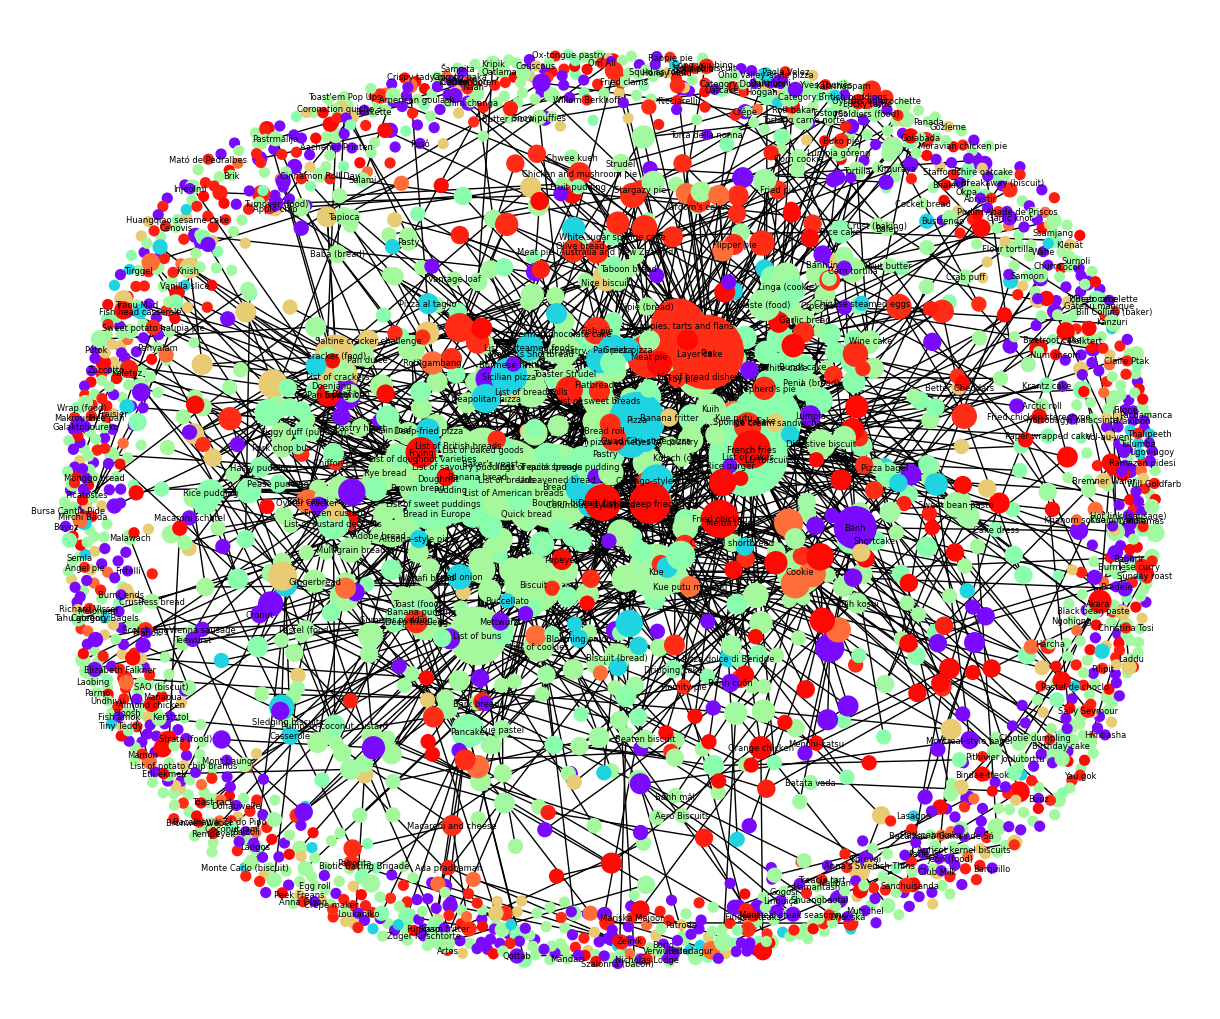

In [117]:
import networkx as nx
import torch_geometric.utils
import matplotlib.pyplot as plt
import matplotlib.cm
from numpy import random

g = torch_geometric.utils.to_networkx(data, to_undirected=True)

node_list = dict(map(lambda i,j : (i,j) , g.nodes, data.articles))
font_size = 6

degrees = dict(g.degree).values()
node_size = [(d+1) * 50 for d in degrees]

idx = 0
for n, l in node_list.items():
    node_list[n] = l if node_size[idx] > 400 else (l if node_size[idx] > 200 and random.rand() > 0.95 else (l if random.rand() > 0.85 else ''))
    idx += 1

pred_list = [p.tolist() for p in pred]
node_pred = [float(p.index(max(p))) for p in pred_list]
node_color = [matplotlib.cm.get_cmap('rainbow')(p/num_classes) for p in node_pred]

fig = plt.figure(1, figsize=(12, 10), dpi=100)
nx.draw(g, labels=node_list, pos=nx.spring_layout(g, k=0.2, iterations=50), font_size=font_size, node_size=node_size, node_color=node_color)